In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import os
import tarfile
import joblib # Imporxst joblib directly
from sklearn.datasets._base import _pkl_filepath, get_data_home
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

In [2]:
from ucimlrepo import fetch_ucirepo

#import data
forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

#Print data info
print(X.info())
print(X.describe())
print(y.head())

#create new dataframe DF
df=X.copy()
df['area'] = y


#create new dataframe df_area which only has values where area != 0
df_area = X.copy()
df_area['area'] = y
df_area = df_area[df_area['area'] > 0]


#print dataframe shapes
X.shape, y.shape, df.shape, df_area.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

((517, 12), (517, 1), (517, 13), (270, 13))

In [3]:
#did some mapping for the words in the dataframe for season.  Based on the month, applied a value instead to a new column season

season_map = {
    "dec": 0, "jan": 0, "feb": 0, "mar": 1, "apr": 1, "may": 1, 
    "jun": 2, "jul": 2, "aug": 2, "sep": 3, "oct": 3, "nov": 3,
}
df_area["season"] = df_area["month"].map(season_map)
df["season"] = df["month"].map(season_map)
X["season"] = X["month"].map(season_map)


#Did the same for the day character column.  if it was a saturday a sunday, gave a 1 flag for yes, otherwise a 0 for no.  Called column is_weekend

weekend_map = {"mon": 0, "tue": 0, "wed": 0, "thu": 0, "fri": 0, "sat": 1, "sun": 1}
df_area["is_weekend"] = df_area["day"].map(weekend_map)
df["is_weekend"] = df["day"].map(weekend_map)
X["is_weekend"] = X["day"].map(weekend_map)

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,season,is_weekend
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,3,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,3,1
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1,1


In [4]:
label_encoder = LabelEncoder()

# Apply encoding to categorical columns month and day.  They are applied alphabetically
X["month_encoded"] = label_encoder.fit_transform(X["month"])
X["day_encoded"] = label_encoder.fit_transform(X["day"])

df["month_encoded"] = label_encoder.fit_transform(df["month"])
df["day_encoded"] = label_encoder.fit_transform(df["day"])

df_area["month_encoded"] = label_encoder.fit_transform(df_area["month"])
df_area["day_encoded"] = label_encoder.fit_transform(df_area["day"])


# Drop original categorical columns\ (will be needed for later)
df = df.drop(columns=["month", "day"])
df_area = df_area.drop(columns=["month", "day"])
X = X.drop(columns=["month", "day"])

In [5]:
#Setup training and test material using original X and Y data imported
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

Training Data: (413, 14), Testing Data: (104, 14)


In [8]:
# Base linear Regression model
base_model = LinearRegression()

#Use training data
base_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = base_model.predict(X_test)

# Evaluate Model Performance
base_mae = mean_squared_error(y_test, y_pred)
base_rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MAE: {base_mae:.3f}")
print(f"Mean Squared Error (RMSE): {base_rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Linear Regression MAE: 11755.385
Mean Squared Error (RMSE): 11755.385
R² Score: 0.003


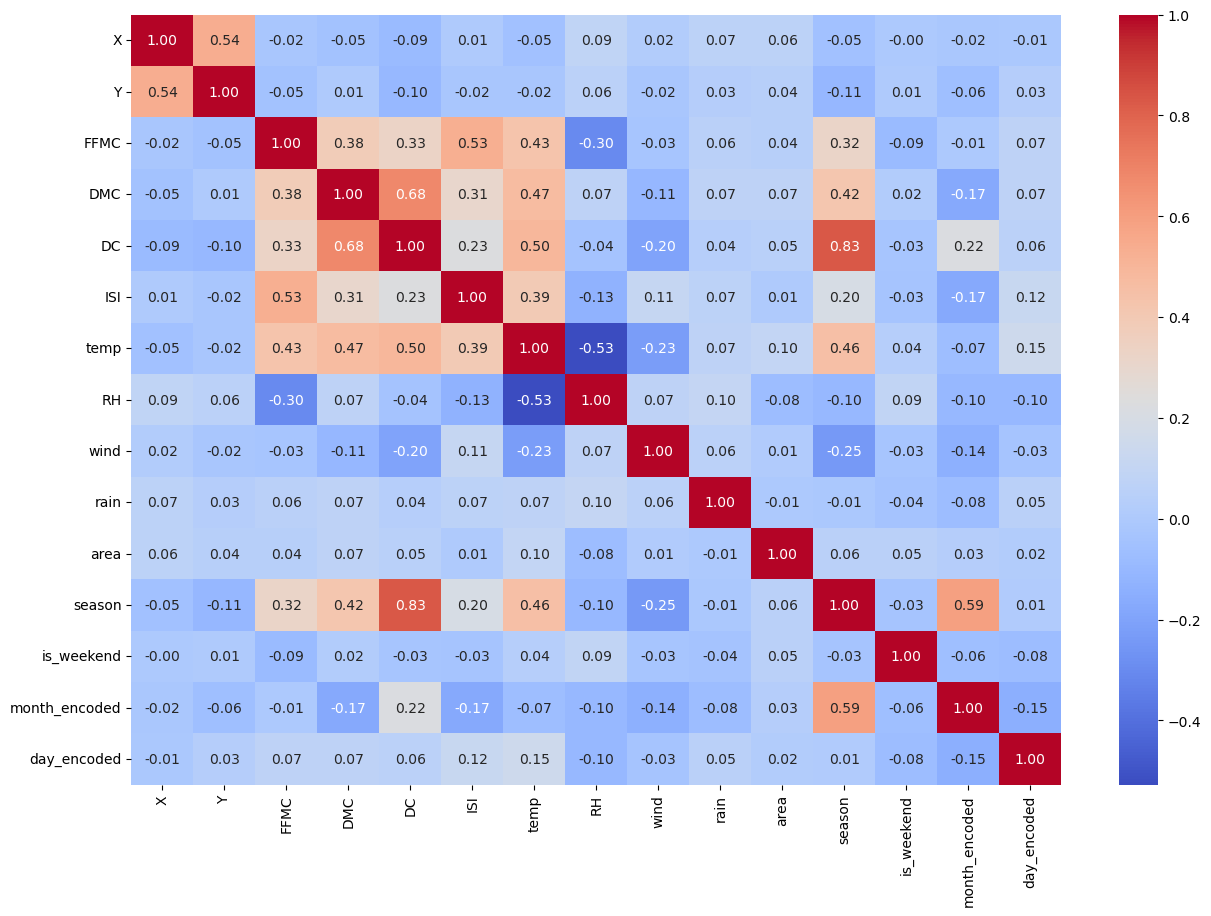

In [9]:
#Correlation matrix for the DF dataframe which allows us to see how much different variables are correlated
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


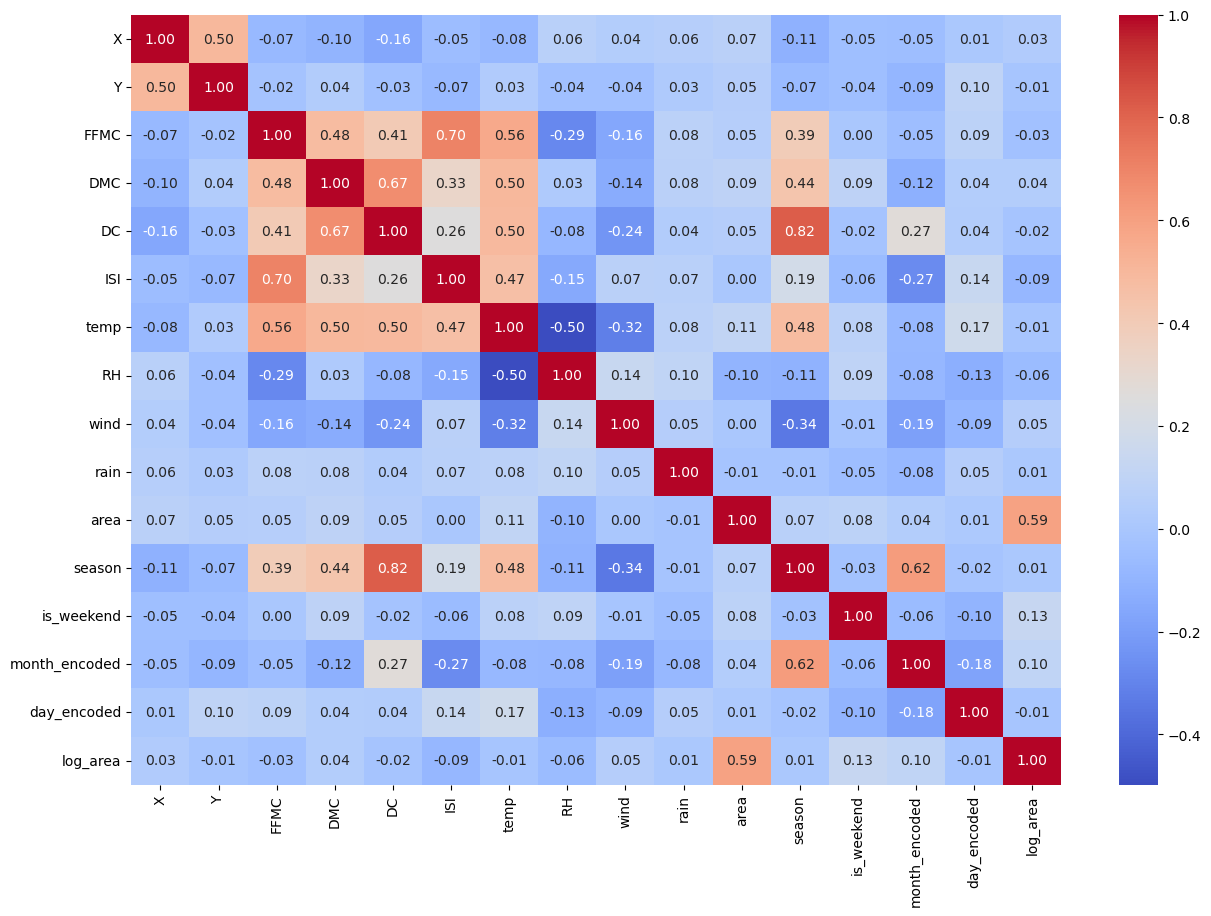

In [10]:
#Correlation matrix again, this time according to the log(area)
df_area['log_area'] = np.log1p(df_area['area'])
corr_matrix = df_area.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [11]:
#Basic ridge model using training data from above
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
print(f"Ridge Model R²: {ridge_model.score(X_test, y_test):.3f}")


Ridge Model R²: 0.003


In [12]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Ridge regression with optimal alpha
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train, y_train)

print(f"Ridge Model R²: {ridge_model.score(X_test, y_test):.3f}")


Ridge Model R²: 0.003


In [13]:

#Scatter Temperature vs Area
#plt.scatter(x=X['temp'], y=y)
#plt.xlabel("Temp (C)")
#plt.ylabel("Area")

In [14]:
#Scatter Rain vs Area
#plt.scatter(x=X['rain'], y=y)
#plt.xlabel("Rain (mm/m2)")
#plt.ylabel("Area")

In [15]:
#Scatter wind vs area
#plt.scatter(x=X['wind'], y=y)
#plt.xlabel("Wind (km/h)")
#plt.ylabel("Area")

In [16]:
#Scatter Month vs area
#plt.scatter(x=X['month'], y=y)
#plt.xlabel("Month)")
#plt.ylabel("Area")

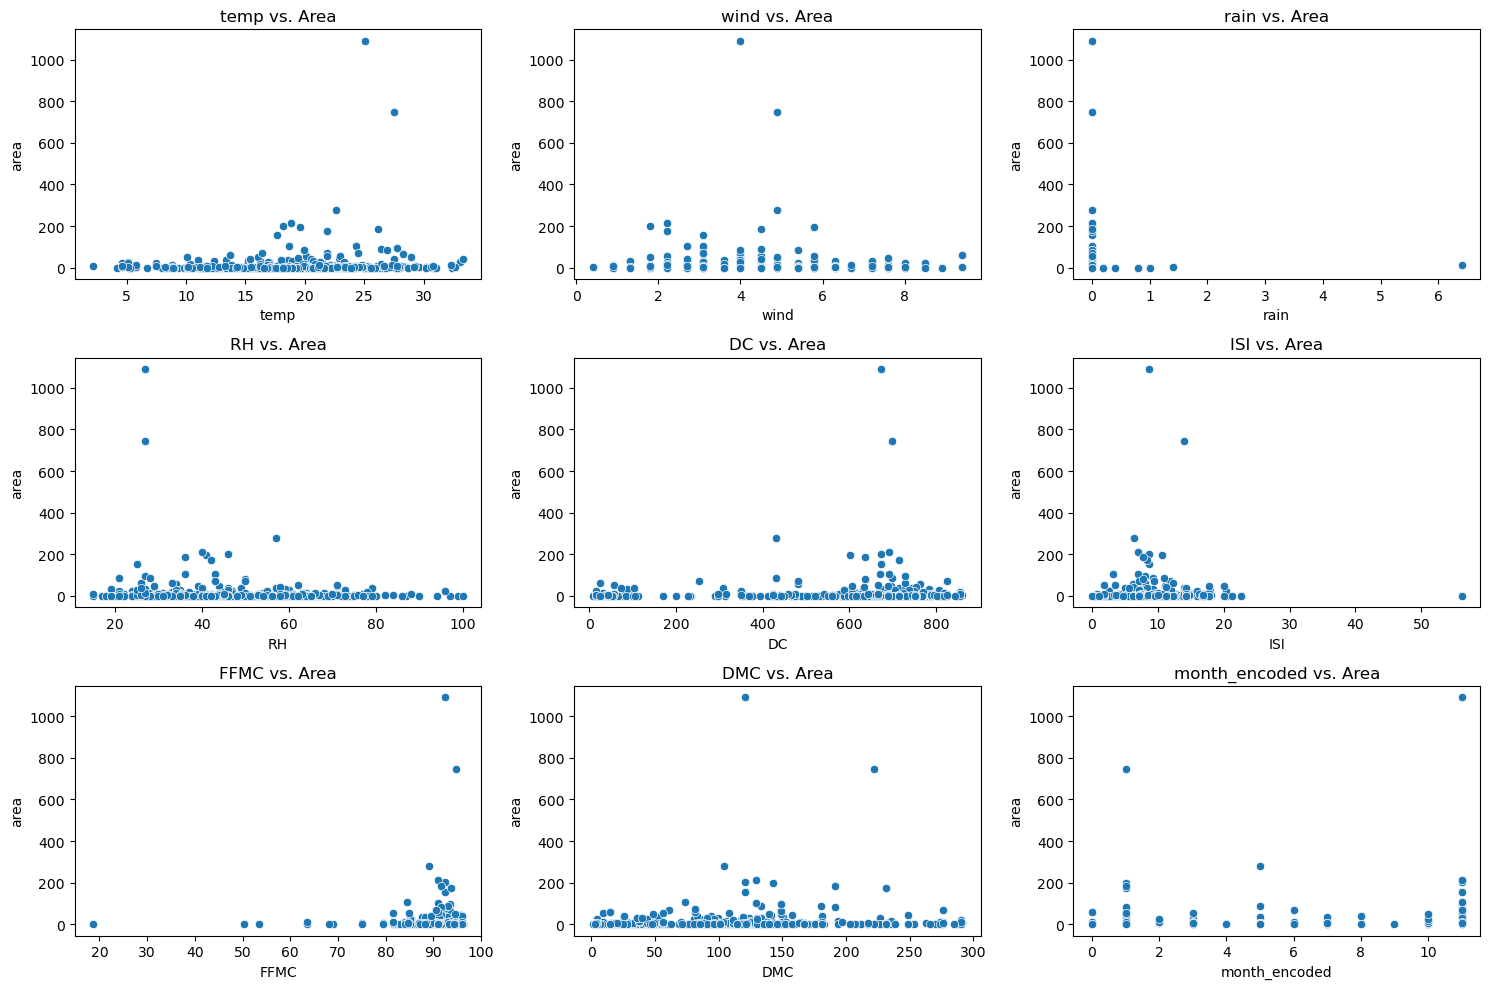

In [17]:
#Create scatter plots for all categories in X compared to the Area in y for a scatter plot visual

y= df['area']
#y= df['log_area']

key_predictors = ['temp', 'wind', 'rain', 'RH', 'DC', 'ISI', 'FFMC', 'DMC', 'month_encoded']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, predictor in enumerate(key_predictors):
    row, col = divmod(i, 3)  # Get subplot position
    sns.scatterplot(x=df[predictor], y=y.squeeze(), ax=axes[row, col])
    axes[row, col].set_title(f"{predictor} vs. Area")

plt.tight_layout()
plt.show()


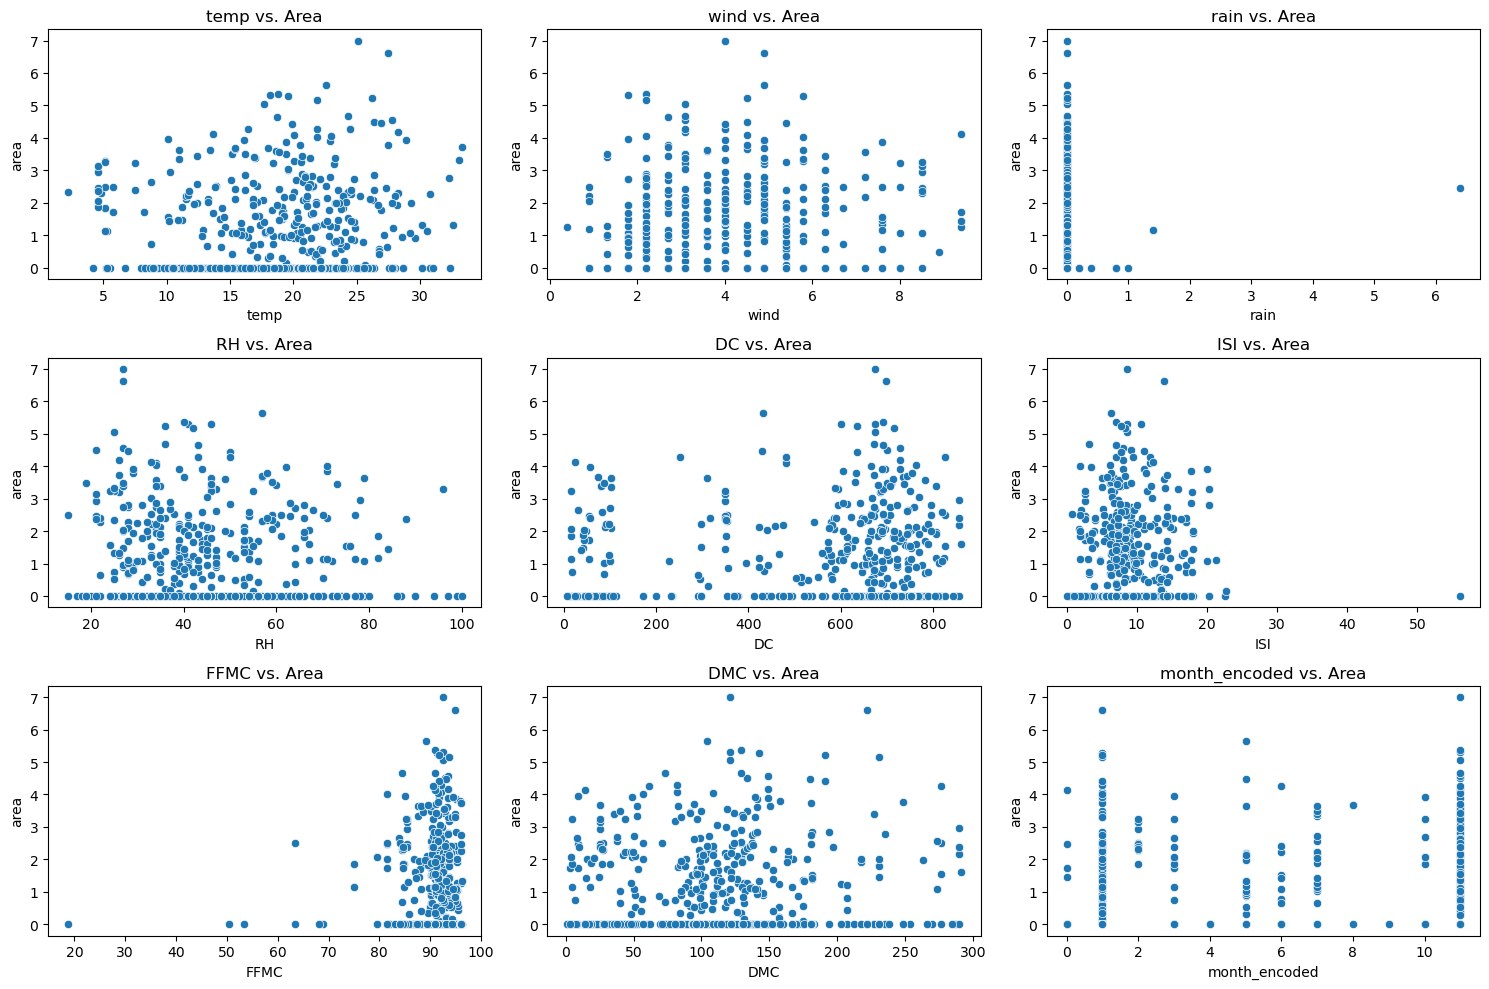

In [18]:
#Same scatterplots as above, but this time correlated to the log(area)

y= np.log1p(df['area'])

key_predictors = ['temp', 'wind', 'rain', 'RH', 'DC', 'ISI', 'FFMC', 'DMC', 'month_encoded']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, predictor in enumerate(key_predictors):
    row, col = divmod(i, 3)  # Get subplot position
    sns.scatterplot(x=df[predictor], y=y.squeeze(), ax=axes[row, col])
    axes[row, col].set_title(f"{predictor} vs. Area")

plt.tight_layout()
plt.show()

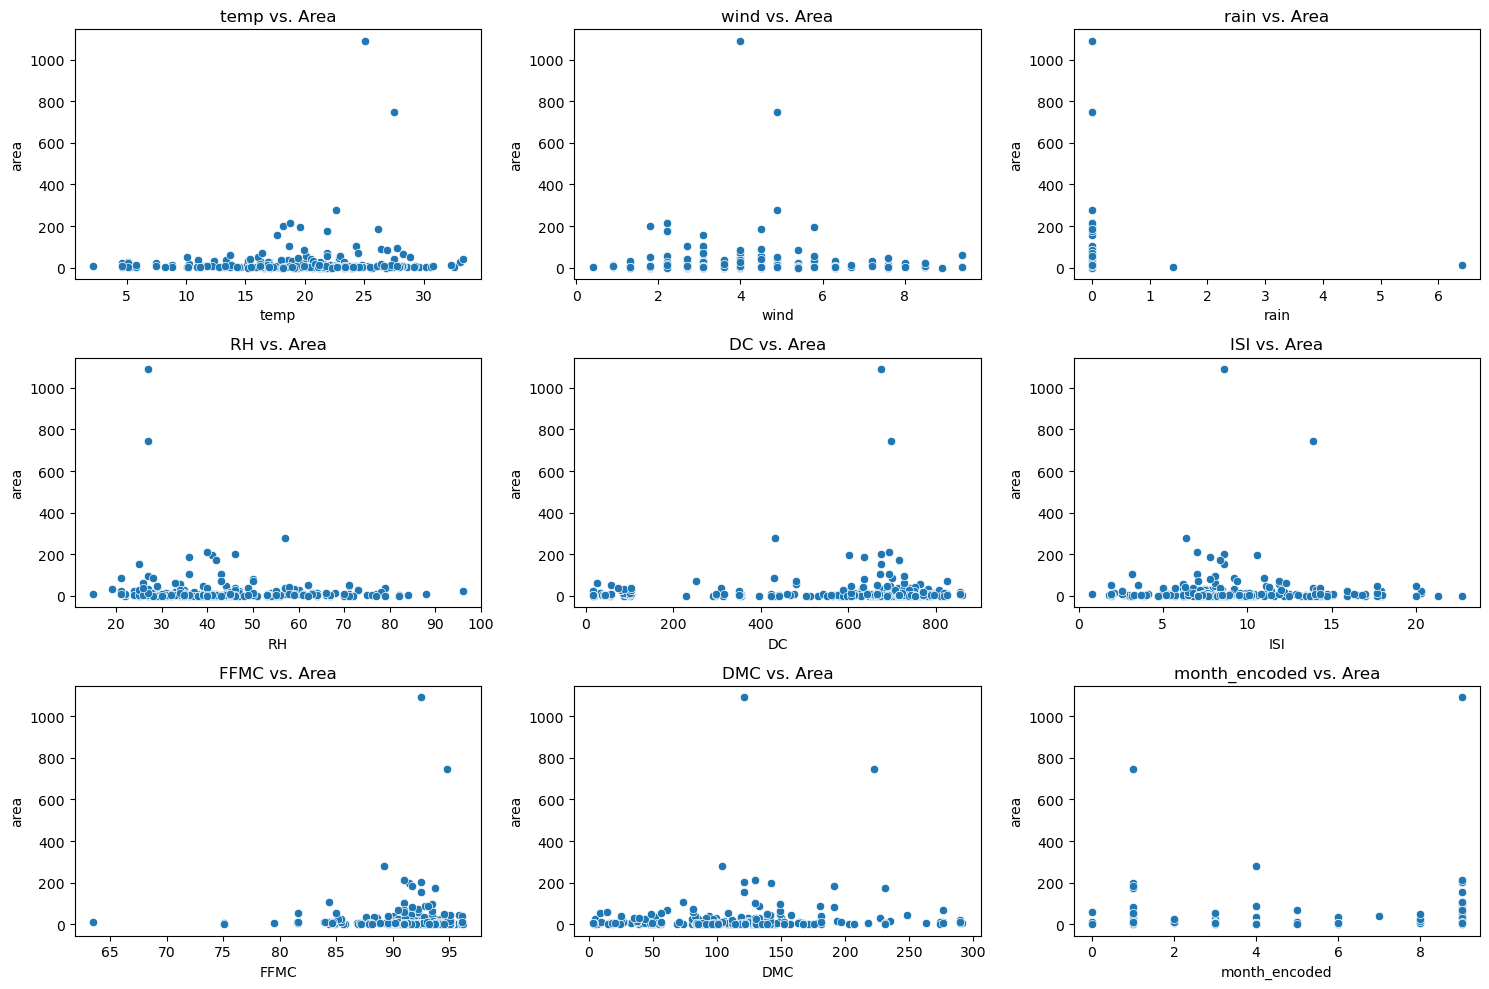

In [19]:
#Scatter plot charts with DF_Area.  Correlates scatter plots for only rows where ara was > 0
y = df_area['area']

key_predictors = ['temp', 'wind', 'rain', 'RH', 'DC', 'ISI', 'FFMC', 'DMC', 'month_encoded']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, predictor in enumerate(key_predictors):
    row, col = divmod(i, 3)  # Get subplot position
    sns.scatterplot(x=df_area[predictor], y=y.squeeze(), ax=axes[row, col])
    axes[row, col].set_title(f"{predictor} vs. Area")

plt.tight_layout()
plt.show()

                      X         Y      FFMC       DMC        DC       ISI  \
X              1.000000  0.539548 -0.021039 -0.048384 -0.085916  0.006210   
Y              0.539548  1.000000 -0.046308  0.007782 -0.101178 -0.024488   
FFMC          -0.021039 -0.046308  1.000000  0.382619  0.330512  0.531805   
DMC           -0.048384  0.007782  0.382619  1.000000  0.682192  0.305128   
DC            -0.085916 -0.101178  0.330512  0.682192  1.000000  0.229154   
ISI            0.006210 -0.024488  0.531805  0.305128  0.229154  1.000000   
temp          -0.051258 -0.024103  0.431532  0.469594  0.496208  0.394287   
RH             0.085223  0.062221 -0.300995  0.073795 -0.039192 -0.132517   
wind           0.018798 -0.020341 -0.028485 -0.105342 -0.203466  0.106826   
rain           0.065387  0.033234  0.056702  0.074790  0.035861  0.067668   
season        -0.053253 -0.108493  0.322135  0.419594  0.827460  0.195651   
is_weekend    -0.004916  0.007725 -0.088094  0.017807 -0.028448 -0.032557   

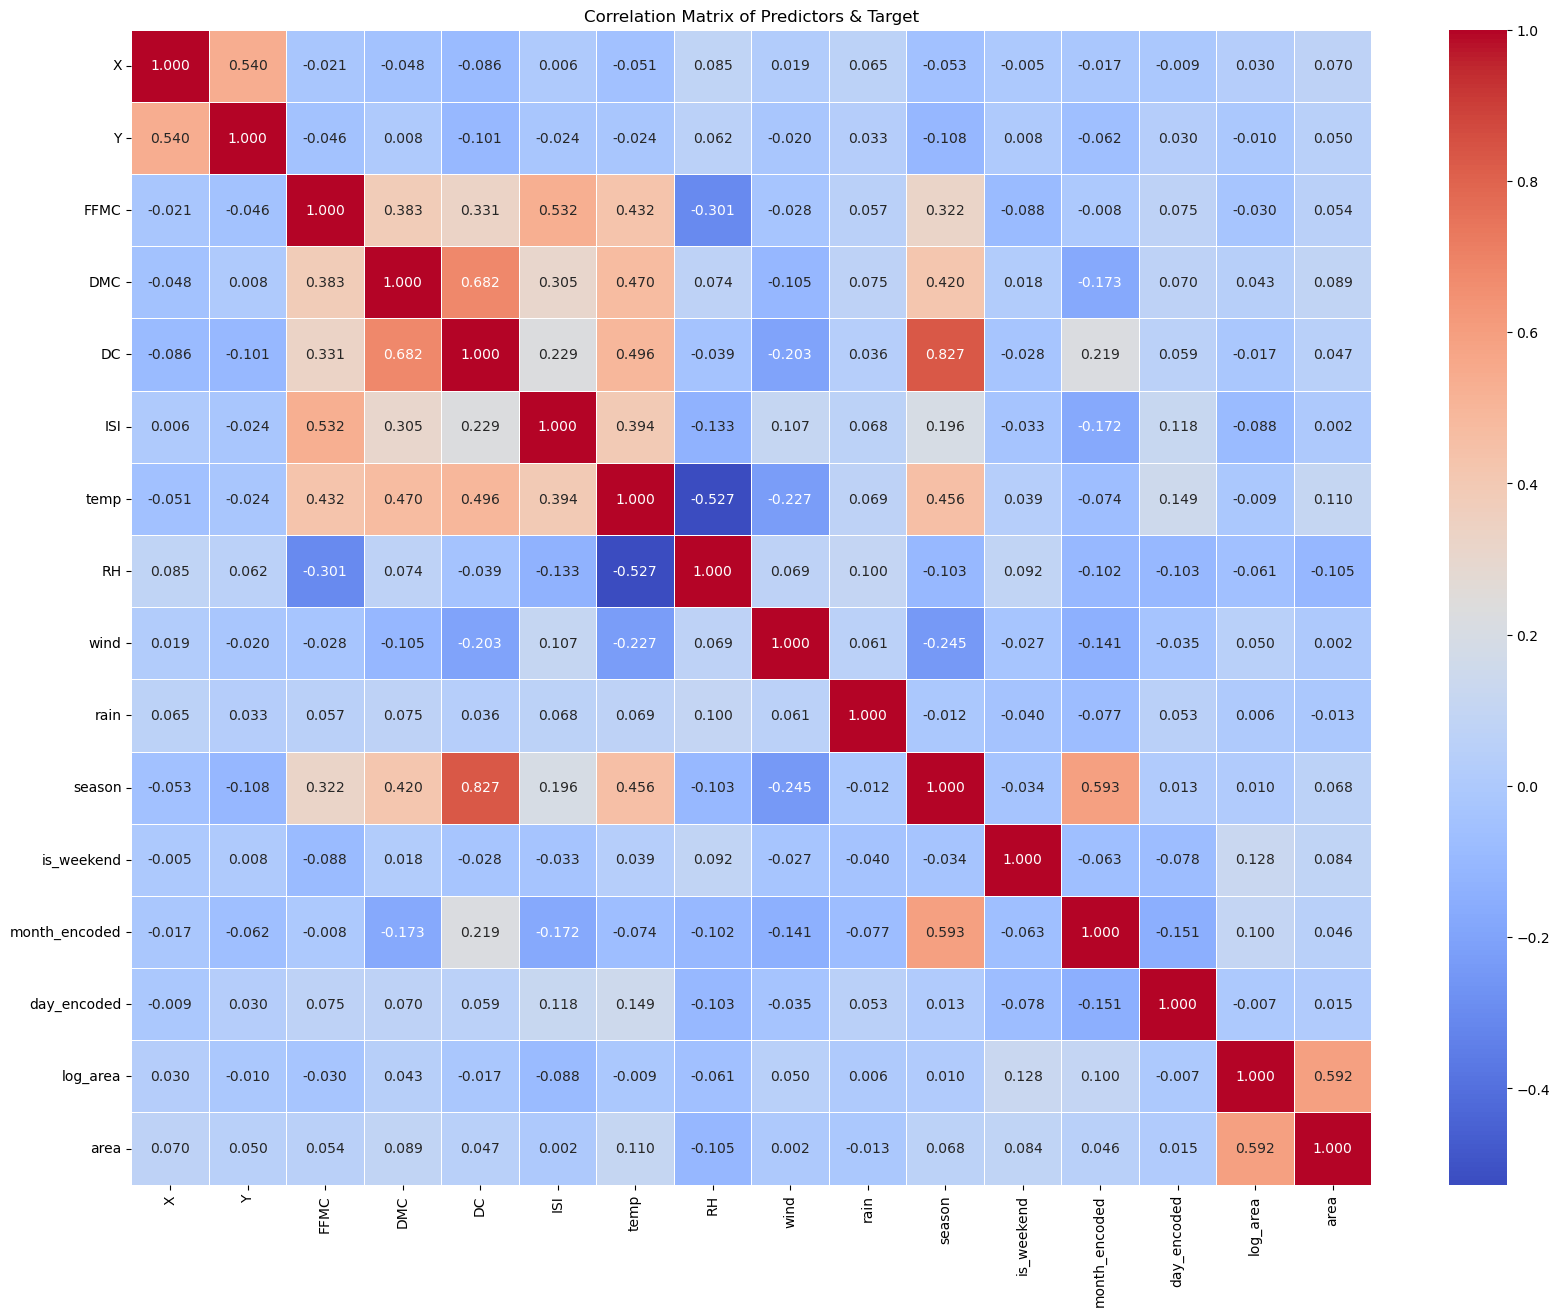

138     0.36
139     0.43
140     0.47
141     0.55
142     0.61
       ...  
509     2.17
510     0.43
512     6.44
513    54.29
514    11.16
Name: area, Length: 270, dtype: float64


In [20]:
#redundant correlation matrix

AllData = X.copy()
AllData['log_area'] = np.log1p(y)
AllData['area'] = y

correlation_matrix = AllData.corr()
print(correlation_matrix)

# Plot heatmap of correlations
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Predictors & Target")
plt.show()


In [21]:
# Base OLS model to start

Xmain = X[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
#Xmain = X[['temp', 'wind', 'RH', 'ISI', 'FFMC']]
y=df['area']


X_const = sm.add_constant(Xmain)

#model = sm.OLS(np.log1p(y), X_const).fit()
model = sm.OLS(y, X_const).fit()

residuals = model.resid

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.033
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.410
Time:                        02:47:11   Log-Likelihood:                -2876.3
No. Observations:                 517   AIC:                             5771.
Df Residuals:                     508   BIC:                             5809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4938     62.048      0.040      0.968    -119.409     124.396
FFMC          -0.0233      0.661     -0.035      0.972      -1.322       1.275
DMC            0.0765      0.067      1.145      0.253      -0.055       0.208
DC            -0.0057      0.016     -0.349      0.727      -0.038       0.026
ISI           -0.6984      0.772     -0.905      0.366      -2.215       0.818
temp           0.8480      0.787      1.077      0.282      -0.699       2.394
RH            -0.1963      0.237     -0.829      0.407      -0.661       0.269
wind           1.5271      1.670      0.914      0.361      -1.754       4.808
rain          -2.5400      9.676     -0.263      0.793     -21.549      16.469
==============================================================================
Omnibus:                      978.059   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           792201.920
Skew:                          12.652   Prob(JB):                         0.00
Kurtosis:                     193.092   Cond. No.                     1.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

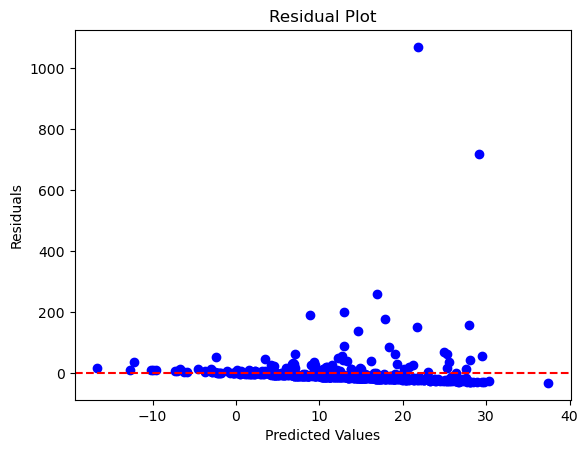

In [22]:
#Residual plot for model

plt.scatter(model.fittedvalues, residuals, color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

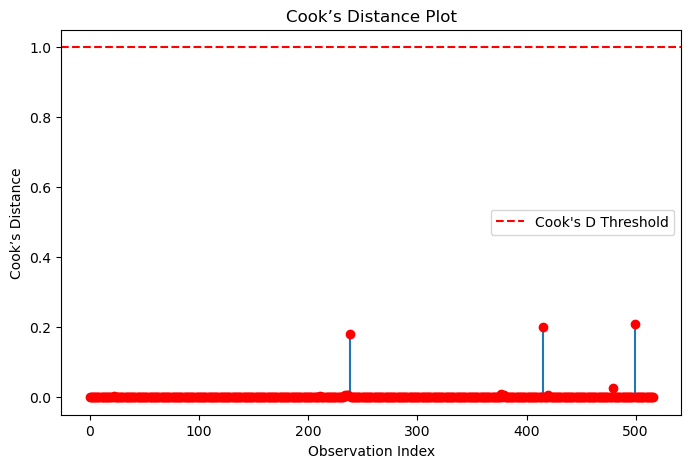

[]


In [23]:
#Cooks D for model above

influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

influential_points = np.where(cooks_d>1)[0]

influential_points.shape



plt.figure(figsize=(8, 5))
plt.stem(range(len(cooks_d)), cooks_d, basefmt=" ", markerfmt="ro")
plt.axhline(y=1, color="red", linestyle="--", label="Cook's D Threshold")
plt.xlabel("Observation Index")
plt.ylabel("Cook’s Distance")
plt.title("Cook’s Distance Plot")
plt.legend()
plt.show()

print(influential_points)

In [24]:
#Base OLS model but using log(area) instead of just area

log_model = sm.OLS(np.log1p(y), X_const).fit()

residuals = log_model.resid

log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.288
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.247
Time:                        02:47:15   Log-Likelihood:                -901.28
No. Observations:                 517   AIC:                             1821.
Df Residuals:                     508   BIC:                             1859.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2224      1.360      0.163      0.870      -2.450       2.895
FFMC           0.0077      0.014      0.532      0.595      -0.021       0.036
DMC            0.0012      0.001      0.814      0.416      -0.002       0.004
DC             0.0003      0.000      0.767      0.444      -0.000       0.001
ISI           -0.0239      0.017     -1.415      0.158      -0.057       0.009
temp           0.0025      0.017      0.143      0.887      -0.031       0.036
RH            -0.0052      0.005     -0.997      0.319      -0.015       0.005
wind           0.0758      0.037      2.069      0.039       0.004       0.148
rain           0.0965      0.212      0.455      0.649      -0.320       0.513
==============================================================================
Omnibus:                       88.885   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.273
Skew:                           1.170   Prob(JB):                     1.89e-29
Kurtosis:                       3.813   Cond. No.                     1.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

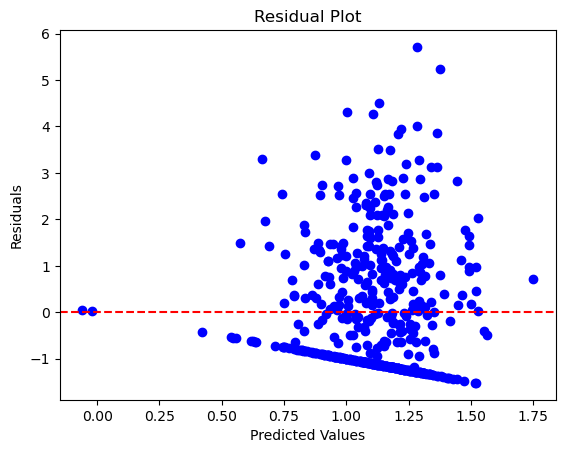

In [26]:
#residual plot according to log(area)

plt.scatter(log_model.fittedvalues, residuals, color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

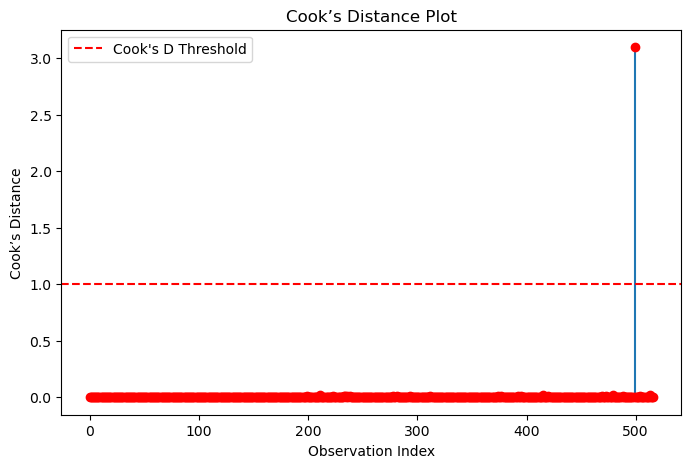

[]


In [27]:
#Cooks D using log(area).  One outlier that could be removed or further investigated

influence = log_model.get_influence()
cooks_d, _ = influence.cooks_distance

influential_points_log = np.where(cooks_d>1)[0]

influential_points_log.shape



plt.figure(figsize=(8, 5))
plt.stem(range(len(cooks_d)), cooks_d, basefmt=" ", markerfmt="ro")
plt.axhline(y=1, color="red", linestyle="--", label="Cook's D Threshold")
plt.xlabel("Observation Index")
plt.ylabel("Cook’s Distance")
plt.title("Cook’s Distance Plot")
plt.legend()
plt.show()

print(influential_points)

In [28]:
#Removed Cooks D outlier and saved into new DF - DF_filtered

print(Xmain.shape)


df_filtered = Xmain.drop(index=influential_points_log)

df_filtered.shape

(517, 8)


(516, 8)

In [66]:
#Base linear model associated to log(area)

X_base = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]  # Feature selection
y_base = np.log1p(df['area'])  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Evaluate performance
r2_base = baseline_model.score(X_test, y_test)
print(f"Baseline Model R²: {r2_base:.3f}")




y_pred = baseline_model.predict(X_test)
mse_base = mean_squared_error(y_test, y_pred)
print(f"Baseline Model MSE: {mse_base:.3f}")

Baseline Model R²: 0.003
Baseline Model MSE: 2.191


In [67]:
df.head()
data = df.copy()
data['log_area'] = np.log1p(data['area'])
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,season,is_weekend,month_encoded,day_encoded,log_area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,7,0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,3,0,10,5,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,3,1,10,2,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,7,0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1,1,7,3,0.0


In [68]:
#Added a bunch of different terms to the data DF.  used the all seperately at different ways. Ultimately went with the model below.  other models were removed as i had to restart from the beginning.

data["temp_wind"] = df["temp"] * data["wind"]
data["RH_DC"] = df["RH"] * data["DC"]
data['temp_squared'] = data['temp'] ** 2
data["log_DC"] = np.log1p(data["DC"])
data["log_DMC"] = np.log1p(data["DMC"])
data['sqrt_wind'] = np.sqrt(data['wind'])
data['log_FFMC'] = np.log1p(data['FFMC'])
data['ISI_RH'] = data['ISI'] * data['RH']
data['log_ISI'] = np.log1p(data['ISI'])
data['RH_squared'] = data['RH'] ** 2
data['month_temp'] = data['month_encoded'] * data['temp']
data['TWDC'] = data['temp']*data['wind']*data['DC']

Random Forest RMSE: 0.546
Random Forest MAE: 0.446
Random Forest R² Score: 0.847


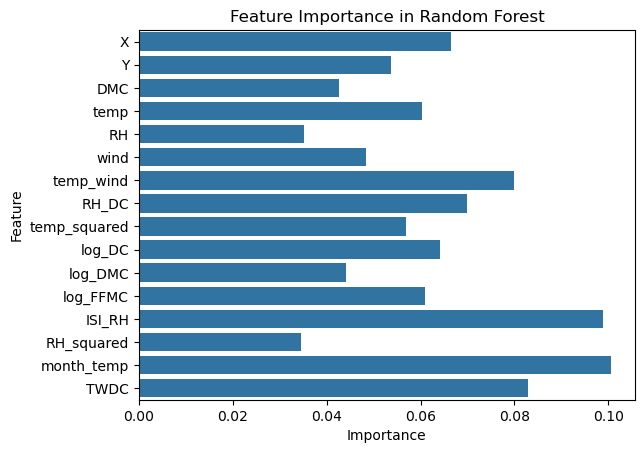

In [73]:
#Random Forest model is below.  Most seamingly correct model.  Dropped a lot of unecessary columns that had no effect on the model according to the chart below.

X_rfr = data.drop(columns=["area", "log_area", "season", "day_encoded", "month_encoded", "is_weekend", "FFMC", "rain", "DC", "sqrt_wind", "ISI", "log_ISI"])
y_rfr = np.log1p(df['area'])


X_train, X_test, y_train, y_test = train_test_split(X_rfr, y_rfr, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rfr, y_rfr)

# Make predictions
y_pred = rf_model.predict(X_rfr)



rmse_rf = mean_squared_error(y_pred, y_rfr, squared=False)

mae_rf = mean_absolute_error(y_pred, y_rfr)

r2_rf = r2_score(y_rfr, y_pred)




print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest R² Score: {r2_rf:.3f}")


feature_importance = rf_model.feature_importances_
sns.barplot(x=feature_importance, y=X_rfr.columns)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.show()


In [74]:
#Ridge Model.  Using the test/training data from the RF_model above

# Scale features (Ridge benefits from standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize & Train Ridge Model
ridge = Ridge(alpha=0.1)  # Tune `alpha` for regularization strength
ridge.fit(X_train_scaled, y_train)

# Make Predictions
y_pred_train = ridge.predict(X_train_scaled)
y_pred_test = ridge.predict(X_test_scaled)

# Compute Metrics
r2_ridge = r2_score(y_test, y_pred_test)
rmse_train_ridge = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test_ridge = mean_squared_error(y_test, y_pred_test, squared=False)
mae_train_ridge = mean_absolute_error(y_train, y_pred_train)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test)


n=len(y_rfr)
p=X_rfr.shape[1]
residuals = y_rfr - ridge.predict(X_rfr)
rss = np.sum(residuals**2)

sigma2 = rss/n

log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - rss / (2 * sigma2)

ridge_aic = 2 * p - 2 * log_likelihood
ridge_bic = p * np.log(n) - 2 * log_likelihood


# Display Results
print(f"Ridge Train RMSE: {rmse_train_ridge:.3f}, Test RMSE: {rmse_test_ridge:.3f}")
print(f"Ridge Train MAE: {mae_train_ridge:.3f}, Test MAE: {mae_test_ridge:.3f}")
print(f"Ridge R² Score: {r2_ridge:.3f}")
print(f"Ridge AIC: {ridge_aic:.3f}")
print(f"Ridge BIC: {ridge_bic:.3f}")

Ridge Train RMSE: 1.327, Test RMSE: 1.480
Ridge Train MAE: 1.070, Test MAE: 1.182
Ridge R² Score: 0.004
Ridge AIC: 10627.541
Ridge BIC: 10695.509


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [34]:
#Lasso Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

lasso_model = Lasso(alpha=0.1)

lasso_model.fit(X_train_scaled, y_train_log)

y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_test = lasso_model.predict(X_test_scaled)


n=len(y_rfr)
p=X_rfr.shape[1]
residuals = y_rfr - lasso_model.predict(X_rfr)
rss = np.sum(residuals**2)

sigma2 = rss/n

log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - rss / (2 * sigma2)

lasso_aic = 2 * p - 2 * log_likelihood
lasso_bic = p * np.log(n) - 2 * log_likelihood


mae_train_lasso = mean_absolute_error(y_train, y_pred_train)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test)

rmse_train_lasso = mean_squared_error(y_train_log, y_pred_train, squared=False)
rmse_test_lasso = mean_squared_error(y_test_log, y_pred_test, squared=False)
r2_lasso = r2_score(y_test_log, y_pred_test)

print(f"Lasso R² Score: {r2_lasso:.3f}")
print(f"Lasso Train Test: {rmse_train_lasso:.3f}")
print(f"Lasso Train MAE: {mae_train_lasso:.3f}, Test MAE: {mae_test_lasso:.3f}")
print(f"Lasso AIC: {lasso_aic:.3f}")
print(f"Lasso BIC: {lasso_bic:.3f}")


Lasso R² Score: -0.000
Lasso Train Test: 0.600
Lasso Train MAE: 1.091, Test MAE: 1.136
Lasso AIC: 1917.203
Lasso BIC: 1976.675


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [35]:
df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,season,is_weekend,month_encoded,day_encoded
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,7,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,3,0,10,5
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,3,1,10,2
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,7,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1,1,7,3


In [36]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  season         517 non-null    int64  
 12  is_weekend     517 non-null    int64  
 13  month_encoded  517 non-null    int64  
 14  day_encoded    517 non-null    int64  
 15  log_area       517 non-null    float64
 16  temp_wind      517 non-null    float64
 17  RH_DC          517 non-null    float64
 18  temp_squar

In [37]:
#Best OLS model found, with the highest F-statistic and R2 and adj. R2 based on the data given to us.  Reference to all the interactive terms created above for the data DF

formula = "log_area ~ X + temp + wind + FFMC + DMC + ISI + month_encoded + ISI_RH + temp_wind + temp_squared + is_weekend + RH_squared + month_temp + TWDC"

ols_model = smf.ols(formula=formula, data=data).fit()

y_pred_ols = ols_model.predict(data)

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_area   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.298
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00464
Time:                        02:47:30   Log-Likelihood:                -890.41
No. Observations:                 517   AIC:                             1811.
Df Residuals:                     502   BIC:                             1875.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0174      1.665      0.611      0.541      -2.253       4.288
X                 0.0449      0.026      1.700      0.090      -0.007       0.097
temp             -0.1626      0.075     -2.159      0.031      -0.310      -0.015
wind              0.1444      0.114      1.271      0.204      -0.079       0.368
FFMC              0.0093      0.016      0.582      0.561      -0.022       0.040
DMC               0.0021      0.001      1.395      0.164      -0.001       0.005
ISI              -0.0402      0.042     -0.958      0.338      -0.123       0.042
month_encoded    -0.0514      0.061     -0.848      0.397      -0.171       0.068
ISI_RH            0.0005      0.001      0.588      0.557      -0.001       0.002
temp_wind        -0.0060      0.007     -0.823      0.411      -0.020       0.008
temp_squared      0.0045      0.002      2.909      0.004       0.001       0.008
is_weekend        0.1284      0.131      0.984      0.326      -0.128       0.385
RH_squared    -8.932e-05   8.92e-05     -1.001      0.317      -0.000     8.6e-05
month_temp        0.0041      0.003      1.363      0.173      -0.002       0.010
TWDC            3.59e-06      5e-06      0.718      0.473   -6.24e-06    1.34e-05
==============================================================================
Omnibus:                       88.183   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.351
Skew:                           1.149   Prob(JB):                     3.00e-29
Kurtosis:                       3.905   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

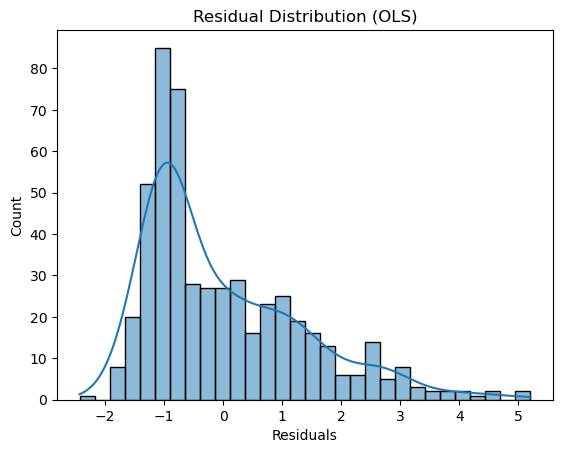

In [39]:
#Visualize residual distributions for OLS model
sns.histplot(ols_model.resid, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution (OLS)")
plt.show()


## Summary of models ran above.  Simple print statements

In [76]:
print(lasso_model)
print(ridge_model)
print(ols_model)
print(rf_model)
print(model)

Lasso(alpha=0.1)
Ridge(alpha=10)
RandomForestRegressor(random_state=42)


In [42]:
#OLS model R2, RMSE, MAE

r2_ols = r2_score(data['log_area'], y_pred_ols)
rmse_ols = mean_squared_error(data['log_area'], y_pred_ols, squared=False)
mae_ols = mean_absolute_error(data['log_area'], y_pred_ols)
aic_ols = ols_model.aic
bic_ols = ols_model.bic

print(f"OLS R² Score: {r2_ols:.3f}")
print(f"OLS RMSE: {rmse_ols:.3f}")
print(f"OLS MAE: {mae_ols:.3f}")
print(f"OLS AIC: {aic_ols:.3f}")
print(f"OLS BIC: {bic_ols:.3f}")

OLS R² Score: 0.060
OLS RMSE: 1.354
OLS MAE: 1.098
OLS AIC: 1810.826
OLS BIC: 1874.547


In [43]:
#Ridge model R2, RMSE, MAE

print(f"Ridge R² Score: {r2_ridge:.3f}")
print(f"Ridge Train RMSE: {rmse_train_ridge:.3f}, Test RMSE: {rmse_test_ridge:.3f}")
print(f"Ridge Train MAE: {mae_train_ridge:.3f}, Test MAE: {mae_test_ridge:.3f}")
print(f"Ridge AIC: {ridge_aic:.3f}")
print(f"Ridge BIC: {ridge_bic:.3f}")

Ridge R² Score: 0.010
Ridge Train RMSE: 1.332, Test RMSE: 1.475
Ridge Train MAE: 1.073, Test MAE: 1.180
Ridge AIC: 10781.606
Ridge BIC: 10841.078


In [44]:
#Lasso

print(f"Lasso R² Score: {r2_lasso:.3f}")
print(f"Lasso Train Test: {rmse_train_lasso:.3f}")
print(f"Lasso Train MAE: {mae_train_lasso:.3f}, Test MAE: {mae_test_lasso:.3f}")
print(f"Lasso AIC: {lasso_aic:.3f}")
print(f"Lasso BIC: {lasso_bic:.3f}")

Lasso R² Score: -0.000
Lasso Train Test: 0.600
Lasso Train MAE: 1.091, Test MAE: 1.136
Lasso AIC: 1917.203
Lasso BIC: 1976.675


In [47]:
#Base linear model

print(f"Linear Regression MAE: {base_mae:.3f}")
print(f"Mean Squared Error (RMSE): {base_rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Linear Regression MAE: 11755.385
Mean Squared Error (RMSE): 11755.385
R² Score: 0.003


In [48]:
#Random Forest
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest R² Score: {r2_rf:.3f}")

Random Forest RMSE: 0.612
Random Forest MAE: 0.482
Random Forest R² Score: 0.808


## OLS Residual & QQ Plot & Cooks

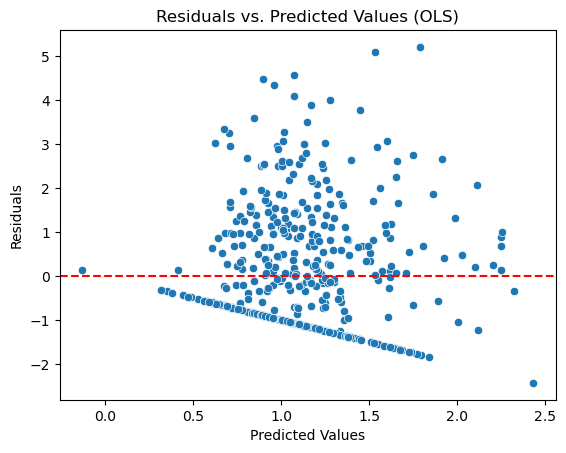

In [49]:
ols_residuals = np.log1p(df['area']) - ols_model.predict(data)

sns.scatterplot(x=ols_model.predict(data), y=ols_residuals)
plt.axhline(y=0, color="red", linestyle="--")  # Reference line
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (OLS)")
plt.show()


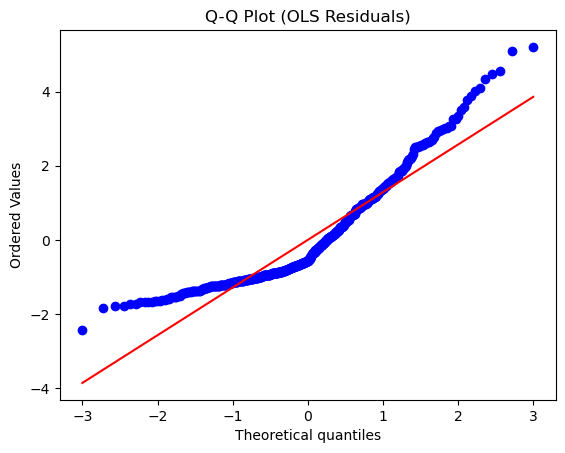

In [50]:
stats.probplot(ols_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot (OLS Residuals)")
plt.show()


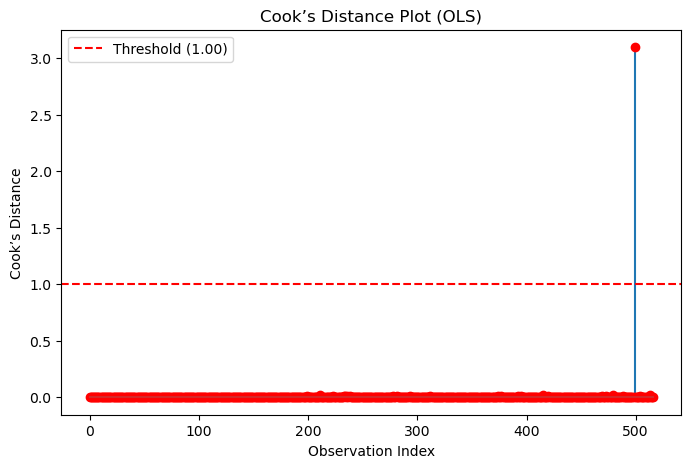

In [51]:
influences = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

plt.figure(figsize=(8,5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt="ro")
plt.axhline(y=1.00, color="red", linestyle="--", label="Threshold (1.00)")
plt.xlabel("Observation Index")
plt.ylabel("Cook’s Distance")
plt.title("Cook’s Distance Plot (OLS)")
plt.legend()
plt.show()


## Random Forest Residual & QQ Plot & Cooks

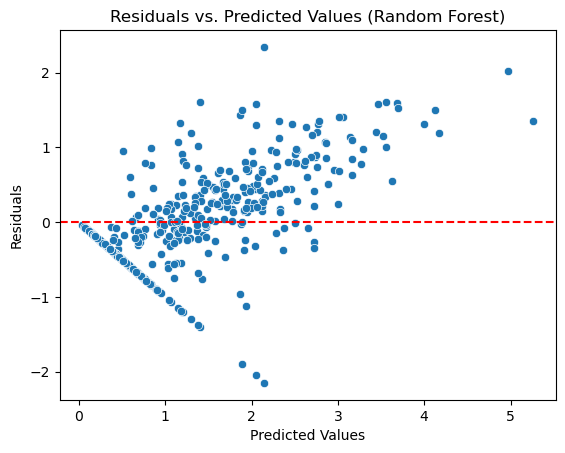

In [52]:
rf_residuals = y_rfr - rf_model.predict(X_rfr)

sns.scatterplot(x=rf_model.predict(X_rfr), y=rf_residuals)
plt.axhline(y=0, color="red", linestyle="--")  # Reference line for zero residuals
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Random Forest)")
plt.show()


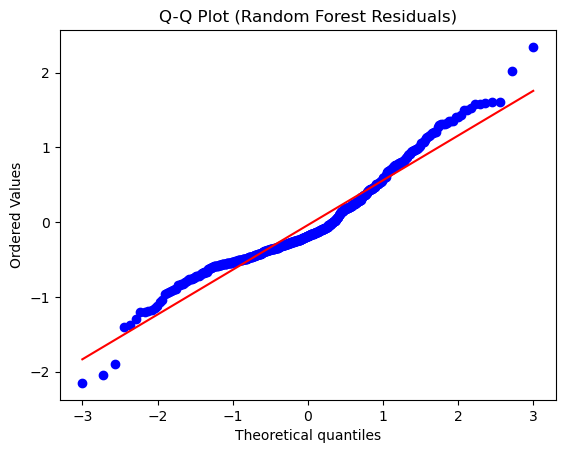

In [53]:
stats.probplot(rf_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot (Random Forest Residuals)")
plt.show()


## Logistical Regression

In [54]:
y = np.log1p(data['area'])

threshold = np.median(y)

y_binary = (y > threshold).astype(int)  # Converts boolean to 0/1

print(f"Threshold Value: {threshold}")
print(f"Binary Target Distribution:\n{np.unique(y_binary, return_counts=True)}")


Threshold Value: 0.41871033485818504
Binary Target Distribution:
(array([0, 1]), array([259, 258]))


In [55]:
from sklearn.feature_selection import SelectKBest, f_classif
print(data.info())

logic_df = data.drop(columns=["area", "log_area"])

selector = SelectKBest(f_classif, k=7)
X_selected = selector.fit_transform(logic_df, y_binary)



#selected_features = ["X" , "temp" , "wind" , "FFMC" , "DMC" , "ISI" , "month_encoded" , "ISI_RH" , "temp_wind" , "temp_squared" , "is_weekend" , "RH_squared" , "month_temp" , "TWDC"]
#X_selected = data[selected_features]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  season         517 non-null    int64  
 12  is_weekend     517 non-null    int64  
 13  month_encoded  517 non-null    int64  
 14  day_encoded    517 non-null    int64  
 15  log_area       517 non-null    float64
 16  temp_wind      517 non-null    float64
 17  RH_DC          517 non-null    float64
 18  temp_squar

In [56]:
scaler = StandardScaler()

# Fit and transform the selected features
X_scaled = scaler.fit_transform(X_selected)



In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Display results
print(f"Logistic Regression Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")

Logistic Regression Accuracy: 0.548
Precision: 0.529, Recall: 0.706, F1-Score: 0.605


In [59]:
print("Intercept:", log_model.intercept_[0])
print("Feature Coefficients:", log_model.coef_)


Intercept: -0.0021646507899143897
Feature Coefficients: [[-0.31110006  0.3511608   0.37207757  0.27573019 -0.04043202  0.5034459
  -0.36767467]]


In [60]:

y_pred_probs = log_model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Convert to binary classification (threshold = 0.5)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)

# Display sample predictions
print("Predicted Probabilities:", np.round(y_pred_probs[:10], 3))
print("Binary Outcomes:", y_pred_binary[:10])


Predicted Probabilities: [0.431 0.522 0.549 0.517 0.561 0.367 0.425 0.547 0.539 0.468]
Binary Outcomes: [0 1 1 1 1 0 0 1 1 0]


In [61]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Display results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.548
Precision: 0.529, Recall: 0.706, F1-Score: 0.605
Confusion Matrix:
 [[21 32]
 [15 36]]


In [78]:
#Calculate Variance Inflation factor for OLS model.  Lots of VIF values above 10 which means high correlation.

predictors = ["X", "temp", "wind", "FFMC", "DMC", "ISI", "month_encoded", 
              "ISI_RH", "temp_wind", "temp_squared", "is_weekend", "RH_squared", 
              "month_temp", "TWDC"]

X_vif = data[predictors]

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

,Feature,VIF
0,const,758.365040
1,X,1.019708
2,temp,52.188125
3,wind,11.322431
4,FFMC,2.103731
5,DMC,2.460624
6,ISI,9.996942
7,month_encoded,19.201030
8,ISI_RH,13.293679
9,temp_wind,18.923340


## Comparison

The most efficient regression model was the Random Forest with an R-squared of 0.83 when the next closest R-squared is using the OLS model which has an value of 0.06.

It also has the smallest MAE and RSME signifying it is the closest model to fit.

In terms of models we learned about during this class, the OLS model is the one that I was able to get closest to a regression models.  Forest fires are very unpredictable, and I'm sure understanding the data and what it all exactly means would help in understanding the values.  But for now I have an OLS model with an R'2 of 0.06 and F-stat of ~2.3.  The adjusted R'2 is lower at a value of 0.034 due to the penalty for the extra parameter variables.  
But all the dat for the model is below.
OLS R² Score: 0.060
OLS RMSE: 1.354
OLS MAE: 1.098
OLS AIC: 1810.826
OLS BIC: 187

It has the lowest AIC and BIC scores, indicating that it is the best choice out of the models completed above.4.547

Ultimately the best model is the random forest, but there is not much data on it above as it does not calculate typical stats we learned about such as AIC or BIC.  You can see on the Q-Q plot how the model is more efficient compared to the OLS model.